In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# frame extraction function
def extract_frames(video_path, output_folder, frame_step=5):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open video file and initialize variables
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0

    # While video is opened
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process every frame if frame_step is None or every frame_step interval
        if frame_step is None or frame_count % frame_step == 0:
            frame_filename = os.path.join(output_folder, f'frame_{extracted_count:04d}.png')
            cv2.imwrite(frame_filename, frame)
            extracted_count += 1

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()
    return extracted_count

def extract_frames_from_folders(root_folder, output_root_folder, frame_step=5):
    if not os.path.exists(output_root_folder):
        os.makedirs(output_root_folder)

    for folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder)
        if os.path.isdir(folder_path):
            # Assuming each folder contains multiple videos, we'll process the first video in each folder
            video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4') or f.endswith('.avi')]
            if len(video_files) > 0:
                video_path = os.path.join(folder_path, video_files[0])
                output_folder = os.path.join(output_root_folder, folder)
                extract_frames(video_path, output_folder, frame_step)
                
# compute optical flow and outputs images, iterating through subdirectories
def compute_optical_flow(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List all subdirectories (fall-01-cam0-rgb to fall-30-cam0-rgb)
    subfolders = sorted([f.name for f in os.scandir(input_folder) if f.is_dir()])

    for folder_name in subfolders:
        input_subfolder = os.path.join(input_folder, folder_name)
        output_subfolder = os.path.join(output_folder, folder_name)
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        frame_files = sorted([os.path.join(input_subfolder, f) for f in os.listdir(input_subfolder) if f.endswith('.png')])

        for i in range(len(frame_files) - 1):
            frame1 = cv2.imread(frame_files[i])
            frame2 = cv2.imread(frame_files[i + 1])

            gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
            gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

            flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv = np.zeros_like(frame1)
            hsv[..., 1] = 255
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            flow_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            flow_filename = os.path.join(output_subfolder, f'flow_{i:04d}.png')
            cv2.imwrite(flow_filename, flow_image)

        print(f'Computed optical flow for {folder_name} with {len(frame_files) - 1} frame pairs')

# compute rank pooling and outputs images, iterating through subdirectories
def rank_pooling(flow_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    subfolders = sorted([f for f in os.listdir(flow_folder) if os.path.isdir(os.path.join(flow_folder, f))])

    for subfolder in subfolders:
        subfolder_path = os.path.join(flow_folder, subfolder)
        output_subfolder = os.path.join(output_folder, subfolder)
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        flow_files = sorted([os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith('.png')])

        accumulated_flow = None
        for i, flow_file in enumerate(flow_files):
            flow_img = cv2.imread(flow_file)
            if accumulated_flow is None:
                accumulated_flow = np.zeros_like(flow_img, dtype=np.float32)
            accumulated_flow += (i + 1) * flow_img

        rank_pooled_image = accumulated_flow / len(flow_files)
        rank_pooled_image = np.clip(rank_pooled_image, 0, 255).astype(np.uint8)

        rank_pooled_filename = os.path.join(output_subfolder, 'rank_pooled.png')
        cv2.imwrite(rank_pooled_filename, rank_pooled_image)

    return output_folder


In [ ]:
# fall frame extraction 
raw_vid_dir = 'MULTICAM-COMPLETE/FALL'
output_frames = 'MULTICAM-COMPLETE/FALL_FRAME'

extract_frames_from_folders(raw_vid_dir, output_frames)

In [ ]:
multicam_of = 'MULTICAM-COMPLETE/FALL_OF'

compute_optical_flow(output_frames, multicam_of)
print(f'Computed optical flow for {len(os.listdir(output_frames))} frame pairs')

Computed optical flow for chute01 with 312 frame pairs
Computed optical flow for chute02 with 166 frame pairs
Computed optical flow for chute03 with 187 frame pairs
Computed optical flow for chute04 with 209 frame pairs
Computed optical flow for chute05 with 153 frame pairs
Computed optical flow for chute06 with 251 frame pairs
Computed optical flow for chute07 with 185 frame pairs
Computed optical flow for chute08 with 142 frame pairs
Computed optical flow for chute09 with 186 frame pairs
Computed optical flow for chute10 with 188 frame pairs
Computed optical flow for chute11 with 164 frame pairs
Computed optical flow for chute12 with 187 frame pairs
Computed optical flow for chute13 with 241 frame pairs
Computed optical flow for chute14 with 299 frame pairs
Computed optical flow for chute15 with 217 frame pairs
Computed optical flow for chute16 with 246 frame pairs
Computed optical flow for chute17 with 307 frame pairs
Computed optical flow for chute18 with 200 frame pairs
Computed o

In [ ]:
raw_nf_dir = 'MULTICAM-COMPLETE/chute24'
output_nf = 'MULTICAM-COMPLETE/NF_FRAME'
nf_of = 'MULTICAM-COMPLETE/NF_OF'

extract_frames_from_folders(raw_nf_dir, output_nf)
compute_optical_flow(output_nf, nf_of )
print(f'Computed optical flow for {len(os.listdir(output_nf))} frame pairs')

Computed optical flow for cam1 with 735 frame pairs
Computed optical flow for cam2 with 741 frame pairs
Computed optical flow for cam3 with 735 frame pairs
Computed optical flow for cam4 with 734 frame pairs
Computed optical flow for cam5 with 741 frame pairs
Computed optical flow for cam6 with 736 frame pairs
Computed optical flow for cam7 with 741 frame pairs
Computed optical flow for cam8 with 728 frame pairs
Computed optical flow for chute24 with -1 frame pairs
Computed optical flow for 9 frame pairs


In [ ]:
# computing optical flow for fall images
input_raw_fall = 'URFD-BALANCED/URFD-FALL/ORI'
fall_optical_flow = 'URFD-BALANCED/URFD-FALL/OF'

compute_optical_flow(input_raw_fall, fall_optical_flow)
print(f'Computed optical flow for {len(os.listdir(input_raw_fall))} frame pairs')

Computed optical flow for fall-01-cam0-rgb with 159 frame pairs
Computed optical flow for fall-02-cam0-rgb with 109 frame pairs
Computed optical flow for fall-03-cam0-rgb with 214 frame pairs
Computed optical flow for fall-04-cam0-rgb with 95 frame pairs
Computed optical flow for fall-05-cam0-rgb with 150 frame pairs
Computed optical flow for fall-06-cam0-rgb with 99 frame pairs
Computed optical flow for fall-07-cam0-rgb with 155 frame pairs
Computed optical flow for fall-08-cam0-rgb with 90 frame pairs
Computed optical flow for fall-09-cam0-rgb with 184 frame pairs
Computed optical flow for fall-10-cam0-rgb with 129 frame pairs
Computed optical flow for fall-11-cam0-rgb with 129 frame pairs
Computed optical flow for fall-12-cam0-rgb with 109 frame pairs
Computed optical flow for fall-13-cam0-rgb with 84 frame pairs
Computed optical flow for fall-14-cam0-rgb with 60 frame pairs
Computed optical flow for fall-15-cam0-rgb with 70 frame pairs
Computed optical flow for fall-16-cam0-rgb wit

In [ ]:
# compute optical flow for daily lives (non-fall) images
input_raw_adl = 'URFD-BALANCED/URFD-ADL/ORI'
adl_optical_flow = 'URFD-BALANCED/URFD-ADL/OF'

compute_optical_flow(input_raw_adl, adl_optical_flow)
print(f'Computed optical flow for {len(os.listdir(input_raw_adl))} frame pairs')

Computed optical flow for adl-01-cam0-rgb with 149 frame pairs
Computed optical flow for adl-02-cam0-rgb with 179 frame pairs
Computed optical flow for adl-03-cam0-rgb with 179 frame pairs
Computed optical flow for adl-04-cam0-rgb with 149 frame pairs
Computed optical flow for adl-05-cam0-rgb with 179 frame pairs
Computed optical flow for adl-06-cam0-rgb with 229 frame pairs
Computed optical flow for adl-07-cam0-rgb with 179 frame pairs
Computed optical flow for adl-08-cam0-rgb with 179 frame pairs
Computed optical flow for adl-09-cam0-rgb with 149 frame pairs
Computed optical flow for adl-10-cam0-rgb with 299 frame pairs
Computed optical flow for adl-11-cam0-rgb with 299 frame pairs
Computed optical flow for adl-12-cam0-rgb with 249 frame pairs
Computed optical flow for adl-13-cam0-rgb with 264 frame pairs
Computed optical flow for adl-14-cam0-rgb with 234 frame pairs
Computed optical flow for adl-15-cam0-rgb with 274 frame pairs
Computed optical flow for adl-16-cam0-rgb with 239 fram

In [ ]:
# compute rank pooling for fall and non-fall images
adl_rank_pool = 'URFD-BALANCED/RP_COMPLETE/RP_ADL'
fall_rank_pool = 'URFD-BALANCED/RP_COMPLETE/RP_FALL'

# rank pooling from URFD Dataset
rank_pooling(adl_optical_flow, adl_rank_pool)
print(f'Computed optical flow for {len(os.listdir(adl_optical_flow))} frame pairs')

rank_pooling(fall_optical_flow, fall_rank_pool)
print(f'Computed optical flow for {len(os.listdir(fall_optical_flow))} frame pairs')

Computed optical flow for 37 frame pairs
Computed optical flow for 30 frame pairs


In [ ]:
print(f'''
      {len(nf_of)}
      {len(multicam_of)}''')


      23
      25


In [ ]:
# rank pooling from MULTICAM Dataset
rank_pooling(nf_of, adl_rank_pool)
print(f'Computed optical flow for {len(os.listdir(nf_of))} frame pairs')

rank_pooling(multicam_of, fall_rank_pool)
print(f'Computed optical flow for {len(os.listdir(multicam_of))} frame pairs')

Computed optical flow for 9 frame pairs
Computed optical flow for 23 frame pairs


In [2]:
BASE_DIR = 'URFD-BALANCED/RP_COMPLETE'
ADL_DIR = os.path.join(BASE_DIR, 'RP_ADL')
FALL_DIR = os.path.join(BASE_DIR, 'RP_FALL')

print(f'''
      {os.listdir(BASE_DIR)}
      non-fall = {len(os.listdir(ADL_DIR))}
      fall = {len(os.listdir(FALL_DIR))}
      ''')


      ['RP_ADL', 'RP_FALL']
      non-fall = 46
      fall = 53
      


In [10]:
# image augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

img_h = 128
img_w = int(img_h * 1.33)

train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size = (img_h,img_w),
    batch_size = 8,
    class_mode = 'categorical',
    shuffle=False,
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    BASE_DIR,
    target_size = (img_h,img_w),
    batch_size = 4,
    class_mode = 'categorical',
    shuffle=False,
    subset = 'validation'
)

Found 80 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


In [11]:
# configure steps for train and val per epoch
train_steps = round(80/8)
val_steps = round(19/4)

print(train_steps)
print(val_steps)

10
5


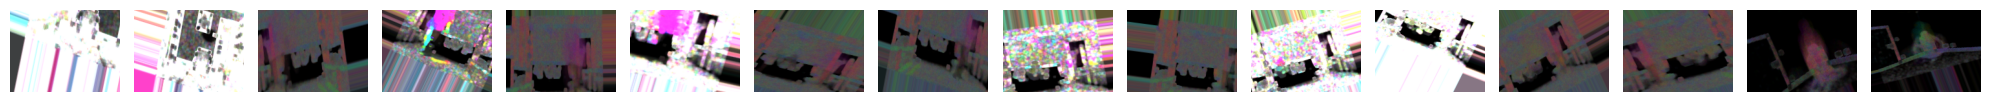

In [ ]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels
sample_images, _ = next(train_generator)

# Plot the images
plot_images(sample_images)

In [4]:
# EfficientNetV2S Model
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Input

# load EfficientNetV2S Model
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_h, img_w, 3)))

for layer in base_model.layers:
    layer.trainable = False

# last_output = base_model.output
base_model.summary()



Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 170, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 170, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 85, 24)           648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 85, 24)           96        ['stem_conv[0][0]']           
 n)                                                                              

In [17]:
# model's architecture
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten

model = tf.keras.models.Sequential([
    base_model,
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2,2)),
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 4, 6, 1280)        20331360  
 al)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 6, 64)          737344    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 3, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 3, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                            
                                                      

In [18]:
# implementing callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the checkpoint path with .keras extension
checkpoint_path = "model_checkpoint.keras"

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# ReduceLROnPlateau callback
lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.1,
    min_lr=0.000001
)

# Custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if acc > 0.97 and val_acc > 0.92:
            print("\nReached desired accuracy so cancelling training!")
            self.model.stop_training = True

early_stop = myCallback()


In [19]:
# compiling the model
model.compile(
    loss ='categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [20]:
# training the model
hist = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 30,
    validation_data = val_generator,
    validation_steps = val_steps,
    verbose = 1,
    callbacks = [lr_reduction, early_stop, checkpoint]
)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.4583 - accuracy: 0.4750
Epoch 1: val_accuracy improved from -inf to 0.47368, saving model to model_checkpoint.keras
10/10 [==============================] - 61s 2s/step - loss: 1.4583 - accuracy: 0.4750 - val_loss: 6.3553 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 2.0827 - accuracy: 0.5500
Epoch 2: val_accuracy improved from 0.47368 to 0.52632, saving model to model_checkpoint.keras
10/10 [==============================] - 8s 810ms/step - loss: 2.0827 - accuracy: 0.5500 - val_loss: 29.9097 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.4999 - accuracy: 0.4000
Epoch 3: val_accuracy did not improve from 0.52632
10/10 [==============================] - 4s 384ms/step - loss: 1.4999 - accuracy: 0.4000 - val_loss: 3.5379 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 4/30
10/10 [==============================]

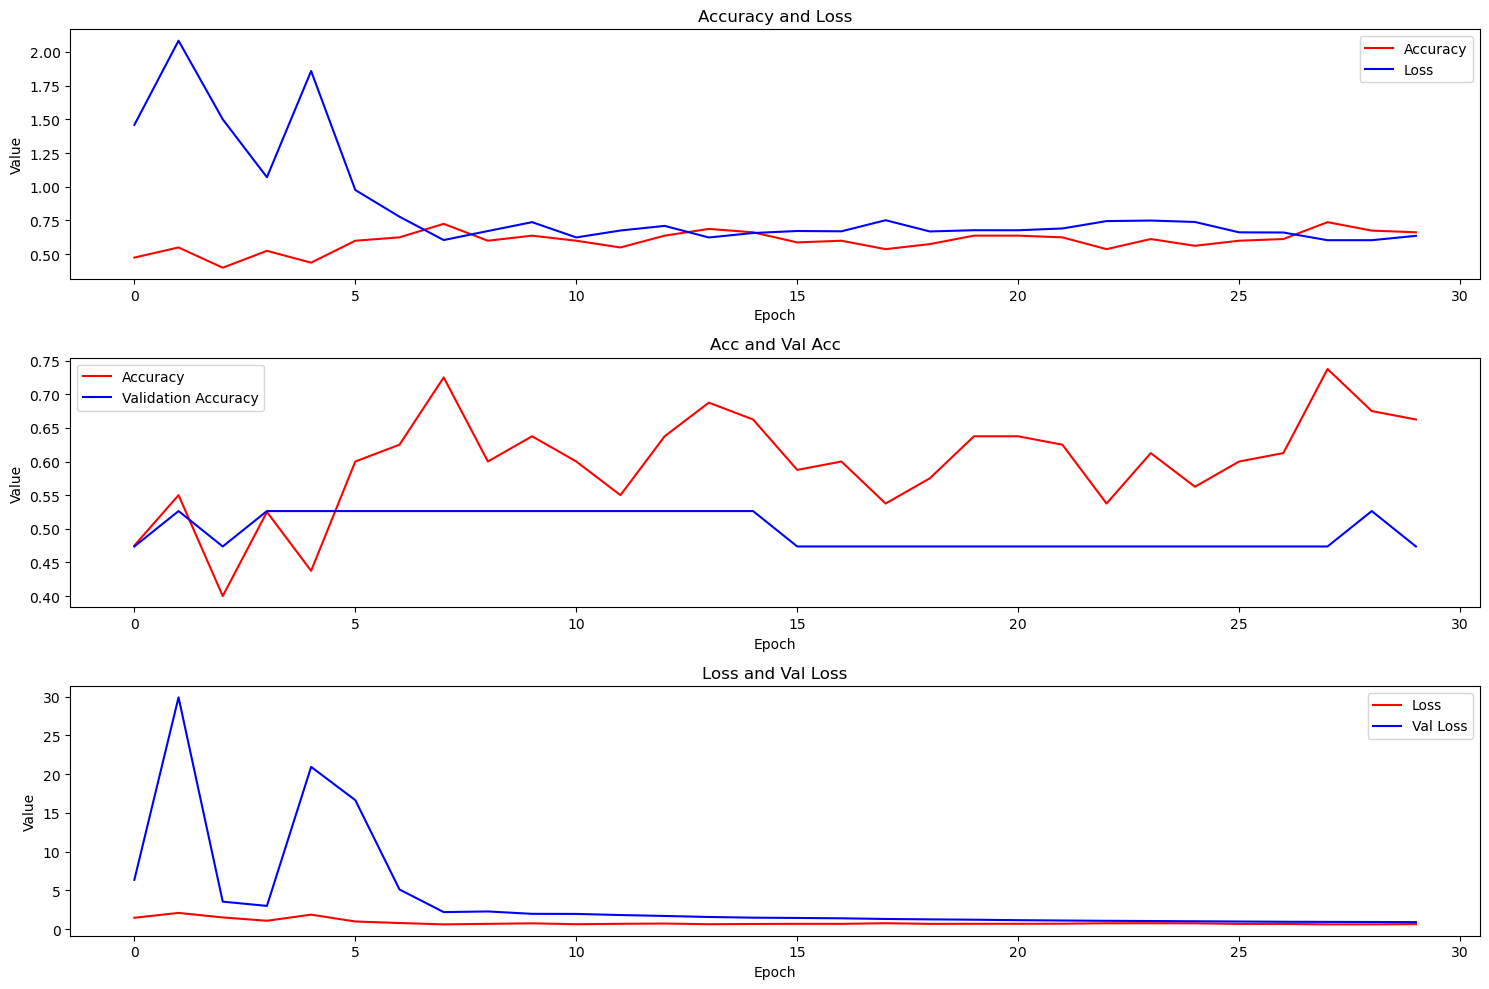

In [21]:
# plotting accuracy and loss
accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
validation_loss = hist.history['val_loss']

fig, ax = plt.subplots(nrows = 3, figsize = (15, 10))

ax[0].plot(accuracy, 'r', label='Accuracy')
ax[0].plot(loss, 'b', label='Loss')
ax[0].set_title('Accuracy and Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].legend(loc = 0)

ax[1].plot(accuracy, 'r', label='Accuracy')
ax[1].plot(validation_accuracy, 'b', label='Validation Accuracy')
ax[1].set_title('Acc and Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend(loc = 0)

ax[2].plot(loss, 'r', label='Loss')
ax[2].plot(validation_loss, 'b', label='Val Loss')
ax[2].set_title('Loss and Val Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')
ax[2].legend(loc = 0)

plt.tight_layout()
plt.show()

5/5 [==============================] - 12s 211ms/step
              precision    recall  f1-score   support

      RP_ADL       0.00      0.00      0.00         9
     RP_FALL       0.53      1.00      0.69        10

    accuracy                           0.53        19
   macro avg       0.26      0.50      0.34        19
weighted avg       0.28      0.53      0.36        19

Sensitivity (Recall) per class:
RP_ADL: 0.00
RP_FALL: 1.00

Specificity per class:
RP_ADL: 1.00
RP_FALL: 0.00


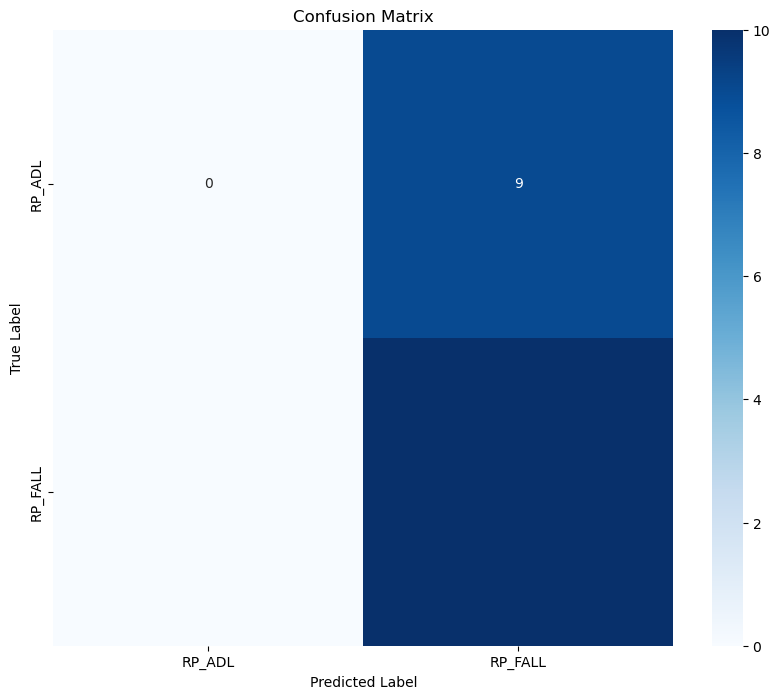

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the model
loaded_model = tf.keras.models.load_model('model_checkpoint.keras')

# Calculate the number of steps to cover the entire validation set
steps = np.ceil(val_generator.samples / val_generator.batch_size)

# Generate predictions
predictions = loaded_model.predict(val_generator, verbose=1)

# Getting the true labels from the generator
y_true = val_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Generating the classification report with zero_division=0
report = classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys(), zero_division=0)
print(report)

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Compute sensitivity (recall) and specificity
def compute_sensitivity_specificity(conf_matrix):
    sensitivity = {}
    specificity = {}
    
    for i, class_label in enumerate(val_generator.class_indices.keys()):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FN + FP)
        
        sensitivity[class_label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[class_label] = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return sensitivity, specificity

sensitivity, specificity = compute_sensitivity_specificity(conf_matrix)

print("Sensitivity (Recall) per class:")
for class_label, value in sensitivity.items():
    print(f"{class_label}: {value:.2f}")

print("\nSpecificity per class:")
for class_label, value in specificity.items():
    print(f"{class_label}: {value:.2f}")

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


Final Prediction from Video

In [24]:
# predict the fall
def predict_fall(rank_pooled_image):
    rank_pooled_image = cv2.resize(rank_pooled_image, (img_w, img_h))  
    rank_pooled_image = rank_pooled_image / 255.0  
    prediction = loaded_model.predict(np.expand_dims(rank_pooled_image, axis=0))
    probability = prediction[0][1]
    return probability > 0.5, probability

# function to overlay text
def overlay_text_on_frame(frame, text, position=(50, 50)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    color = (0, 0, 255) 
    thickness = 2
    frame = cv2.putText(frame, text, position, font, font_scale, color, thickness, cv2.LINE_AA)
    return frame

# create video from overlayed sequences of images
def create_video(frames, output_path, fps=25):
    height, width, layers = frames[0].shape
    size = (width, height)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for frame in frames:
        out.write(frame)
    out.release()

# final prediction pipeline
def process_sequences(frames_folder, rp_folder, output_video_path, sequence_length=16):
    subfolders = sorted([f for f in os.listdir(frames_folder) if os.path.isdir(os.path.join(frames_folder, f))])

    for subfolder in subfolders:
        subfolder_path = os.path.join(frames_folder, subfolder)
        frame_files = sorted([os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith('.png')])
        
        rp_image_path = os.path.join(rp_folder, subfolder, 'rank_pooled.png')
        if not os.path.exists(rp_image_path):
            print(f"Rank pooled image not found for {subfolder}")
            continue

        rank_pooled_image = cv2.imread(rp_image_path)
        is_fall, probability = predict_fall(rank_pooled_image)

        frames = [cv2.imread(frame_file) for frame_file in frame_files]
        sequences = [frames[i:i+sequence_length] for i in range(0, len(frames), sequence_length)]

        processed_frames = []
        for seq in sequences:
            if len(seq) < sequence_length:
                break

            label = f"Fall ({probability:.2f})" if is_fall else f"No Fall ({probability:.2f})"
            seq = [overlay_text_on_frame(frame, label) for frame in seq]
            processed_frames.extend(seq)

        create_video(processed_frames, output_video_path)

NF_vid = 'Final_Testing/INPUT/NONFALL'
NF_Frames = 'Final_Testing/INPUT/NF_FRAME'

fall_vid = 'Final_Testing/INPUT/FALL'
fall_Frames = 'Final_Testing/INPUT/FALL_FRAME'

NF_test_of = 'Final_Testing/INPUT/NF_OF'
fall_test_of = 'Final_Testing/INPUT/FALL_OF'

NF_test_RP = 'Final_Testing/INPUT/NF_RP'
fall_test_RP = 'Final_Testing/INPUT/FALL_RP'

# extract_frames_from_folders(NF_vid, NF_Frames)
# extract_frames_from_folders(fall_vid, fall_Frames)

# compute_optical_flow(NF_Frames, NF_test_of)
# compute_optical_flow(fall_Frames, fall_test_of)

# rank_pooling(NF_test_of, NF_test_RP)
# rank_pooling(fall_test_of, fall_test_RP)

process_sequences(NF_Frames, NF_test_RP, 'Final_Testing/OUTPUT/no_fall.mp4')
process_sequences(fall_Frames, fall_test_RP, 'FINAL_TESTING/OUTPUT/fall.mp4')

1/1 [==============================] - 0s 269ms/step
